In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
from datetime import datetime
import numpy as np
import tensorflow as tf
from steel_seg.utils import (
    dice_coeff_kaggle,
    rle_to_dense,
    dense_to_rle,
    visualize_segmentations,
    onehottify)
from steel_seg.dataset.severstal_steel_dataset import SeverstalSteelDataset
from steel_seg.model.unet import build_unet_model
from steel_seg.model.classification_wrapper import build_classification_model
from steel_seg.train import (
    class_weighted_binary_classification_crossentropy,
    binary_accuracy_by_class)
import matplotlib.pyplot as plt
%matplotlib inline

/home/ryan/src/steel_seg/env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Necessary for CUDA 10 or something?
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = "1"
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_LOSS_SCALING"] = "1"

In [4]:
with open('SETTINGS.yaml') as f:
    cfg = yaml.load(f)

/home/ryan/src/steel_seg/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [5]:
dataset = SeverstalSteelDataset.init_from_config('SETTINGS.yaml')

/home/ryan/src/steel_seg/steel_seg/dataset/severstal_steel_dataset.py:84: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(f)


In [6]:
train_data, train_batches = dataset.create_dataset(dataset_type='training', dense_segmentation=False)
val_data, val_batches = dataset.create_dataset(dataset_type='validation', dense_segmentation=False)

W0926 22:37:38.630422 139620787279680 deprecation_wrapper.py:119] From /home/ryan/src/steel_seg/steel_seg/dataset/severstal_steel_dataset.py:179: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.

W0926 22:37:38.630986 139620787279680 deprecation_wrapper.py:119] From /home/ryan/src/steel_seg/steel_seg/dataset/severstal_steel_dataset.py:183: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



In [7]:
seg_model = build_unet_model(
    img_height=cfg['IMG_HEIGHT'],
    img_width=cfg['IMG_WIDTH'],
    img_channels=1,
    num_classes=cfg['NUM_CLASSES'],
    num_layers=4,
    activation=tf.keras.activations.elu,
    kernel_initializer='he_normal',
    kernel_size=(3, 3),
    pool_size=(2, 4),
    num_features=[32, 64, 128, 256],
    drop_prob=0.5)
model_checkpoint_name = 'deep'

W0926 22:37:38.870577 139620787279680 deprecation.py:506] From /home/ryan/src/steel_seg/env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 1600, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 1600, 32 320         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 1600, 32 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
!ls checkpoints

basic_20190915-235831  deep_20190916-092052


In [10]:
date_str = '20190916-092052'

In [11]:
checkpoint_name = f'{model_checkpoint_name}_{date_str}'
checkpoint_path = f'checkpoints/{checkpoint_name}/cp-{checkpoint_name}' + '-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
initial_epoch = 0
if latest_checkpoint is None:
    print('Error. No checkpoints found.')
else:
    print(f'Loading weights from {latest_checkpoint}')
    last_epoch = latest_checkpoint.split('-')[-1]
    last_epoch = last_epoch.split('.')[0]
    initial_epoch = int(last_epoch)
    seg_model.load_weights(latest_checkpoint)

Loading weights from checkpoints/deep_20190916-092052/cp-deep_20190916-092052-0309.ckpt


In [12]:
cls_model = build_classification_model(seg_model, 'conv2d_7', 4, 'conv2d_14')
model_checkpoint_name = 'classifier' # TODO: cleanup this hack

Tensor("conv2d_14/Sigmoid:0", shape=(?, 256, 1600, 4), dtype=float32)


In [13]:
cls_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 1600, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 1600, 32 320         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 1600, 32 0           conv2d[0][0]                     
____________________________________________________________________________________________

In [14]:
# train_imgs = dataset.get_image_list('training')
# class_counts = np.zeros((4,))
# for img_name in train_imgs:
#     img, ann = dataset.get_example_from_img_name(img_name)
#     class_counts += np.amax(ann, axis=(0, 1))
# np.array([len(train_imgs)] * 4) / class_counts

In [15]:
#cls_weights = [30.0, 40.0, 10.0, 20.0]
cls_weights = [14.15538847, 53.28301887,  2.43921399, 15.62378976]

In [16]:
cls_model.compile(
    optimizer=tf.train.AdamOptimizer(0.0001),
    loss={'classification_output': class_weighted_binary_classification_crossentropy(cls_weights)},
    metrics={'classification_output': [
        binary_accuracy_by_class(0),
        binary_accuracy_by_class(1),
        binary_accuracy_by_class(2),
        binary_accuracy_by_class(3),
    ]}
)

W0926 22:37:42.134924 139620787279680 training_utils.py:1101] Output conv2d_14 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to conv2d_14.
W0926 22:37:42.163885 139620787279680 deprecation.py:323] From /home/ryan/src/steel_seg/steel_seg/train.py:247: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0926 22:37:42.209861 139620787279680 deprecation.py:323] From /home/ryan/src/steel_seg/env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
!ls classification_checkpoints

classifier_20190925-232140  classifier_20190926-222704


In [18]:
#date_str = '20190925-232140' # First try, probably not great weights
date_str = datetime.now().strftime("%Y%m%d-%H%M%S")
date_str

'20190926-223743'

In [19]:
checkpoint_name = f'{model_checkpoint_name}_{date_str}'
checkpoint_path = f'classification_checkpoints/{checkpoint_name}/cp-{checkpoint_name}' + '-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
initial_epoch = 0
if latest_checkpoint is None:
    print('No checkpoints found. Starting from scratch.')
else:
    print(f'Loading weights from {latest_checkpoint}')
    last_epoch = latest_checkpoint.split('-')[-1]
    last_epoch = last_epoch.split('.')[0]
    initial_epoch = int(last_epoch)
    cls_model.load_weights(latest_checkpoint)

No checkpoints found. Starting from scratch.


In [20]:
# Create checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='auto',
    save_weights_only=True,
    verbose=1)


logdir = f'logs/{checkpoint_name}-{initial_epoch}'
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logdir),
    checkpoint_cb,
]

results = cls_model.fit(
    train_data,
    epochs=400,
    verbose=2,
    callbacks=callbacks,
    validation_data=val_data,
    steps_per_epoch=train_batches,
    validation_steps=val_batches,
    validation_freq=1,
    initial_epoch=initial_epoch)

Epoch 1/400


W0926 22:39:18.783638 139620787279680 callbacks.py:989] Can save best model only with val_loss available, skipping.


2824/2824 - 89s - loss: 7.8573 - classification_output_loss: 7.8573 - classification_output__binary_accuracy_by_class_0: 0.7844 - classification_output__binary_accuracy_by_class_1: 0.8430 - classification_output__binary_accuracy_by_class_2: 0.7729 - classification_output__binary_accuracy_by_class_3: 0.8737
Epoch 2/400


W0926 22:40:44.053350 139620787279680 callbacks.py:989] Can save best model only with val_loss available, skipping.


2824/2824 - 85s - loss: 1.6736 - classification_output_loss: 1.6736 - classification_output__binary_accuracy_by_class_0: 0.8584 - classification_output__binary_accuracy_by_class_1: 0.8658 - classification_output__binary_accuracy_by_class_2: 0.8413 - classification_output__binary_accuracy_by_class_3: 0.9261
Epoch 3/400

Epoch 00003: val_loss improved from inf to 1.23670, saving model to classification_checkpoints/classifier_20190926-223743/cp-classifier_20190926-223743-0003.ckpt
2824/2824 - 93s - loss: 1.0772 - classification_output_loss: 1.0772 - classification_output__binary_accuracy_by_class_0: 0.8787 - classification_output__binary_accuracy_by_class_1: 0.8866 - classification_output__binary_accuracy_by_class_2: 0.8616 - classification_output__binary_accuracy_by_class_3: 0.9478 - val_loss: 1.2367 - val_classification_output_loss: 1.2367 - val_classification_output__binary_accuracy_by_class_0: 0.8822 - val_classification_output__binary_accuracy_by_class_1: 0.9022 - val_classification_

W0926 22:43:41.994813 139620787279680 callbacks.py:989] Can save best model only with val_loss available, skipping.


2824/2824 - 85s - loss: 0.9196 - classification_output_loss: 0.9196 - classification_output__binary_accuracy_by_class_0: 0.8940 - classification_output__binary_accuracy_by_class_1: 0.9080 - classification_output__binary_accuracy_by_class_2: 0.8691 - classification_output__binary_accuracy_by_class_3: 0.9575
Epoch 5/400


W0926 22:45:04.387312 139620787279680 callbacks.py:989] Can save best model only with val_loss available, skipping.


2824/2824 - 82s - loss: 0.7018 - classification_output_loss: 0.7018 - classification_output__binary_accuracy_by_class_0: 0.9098 - classification_output__binary_accuracy_by_class_1: 0.9220 - classification_output__binary_accuracy_by_class_2: 0.8816 - classification_output__binary_accuracy_by_class_3: 0.9659
Epoch 6/400

Epoch 00006: val_loss did not improve from 1.23670
2824/2824 - 87s - loss: 0.6658 - classification_output_loss: 0.6658 - classification_output__binary_accuracy_by_class_0: 0.9230 - classification_output__binary_accuracy_by_class_1: 0.9434 - classification_output__binary_accuracy_by_class_2: 0.8834 - classification_output__binary_accuracy_by_class_3: 0.9673 - val_loss: 1.3112 - val_classification_output_loss: 1.3112 - val_classification_output__binary_accuracy_by_class_0: 0.9239 - val_classification_output__binary_accuracy_by_class_1: 0.9159 - val_classification_output__binary_accuracy_by_class_2: 0.8742 - val_classification_output__binary_accuracy_by_class_3: 0.9888
Epoc

KeyboardInterrupt: 

# Evaluate

In [21]:
# Note: you may have to reload the model (without compiling) before evaluating
# The act of compiling the model with only one loss function messes things up.

In [22]:
val_imgs = dataset.get_image_list('validation')
len(val_imgs)

1248

In [23]:
y_preds = np.zeros((len(val_imgs), 4), dtype=np.float32)
y_true = np.zeros((len(val_imgs), 4), dtype=np.uint8)

for i, img_name in enumerate(val_imgs):
    img, ann = dataset.get_example_from_img_name(img_name)
    img_batch = np.expand_dims(img, axis=0)
    y_seg, y_cls = cls_model.predict(img_batch)
    
    y_true[i, :] = np.amax(ann, axis=(0, 1))
    y_preds[i, :] = y_cls[0, :]
    

In [24]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

Confusion matric for class {i}
(Actual labels on left)
              0     1 
        0 1001.0 150.0 
        1   5.0  92.0 


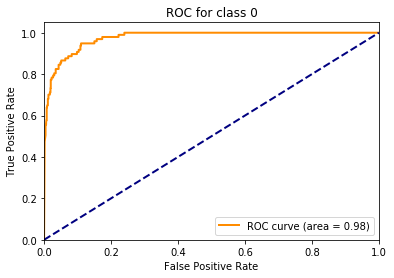

Confusion matric for class {i}
(Actual labels on left)
              0     1 
        0 1095.0 119.0 
        1   2.0  32.0 


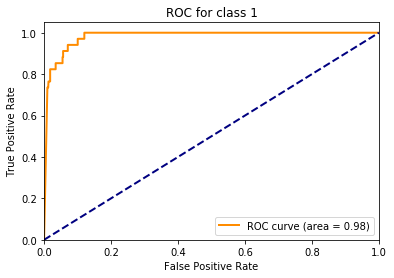

Confusion matric for class {i}
(Actual labels on left)
              0     1 
        0 648.0  89.0 
        1  67.0 444.0 


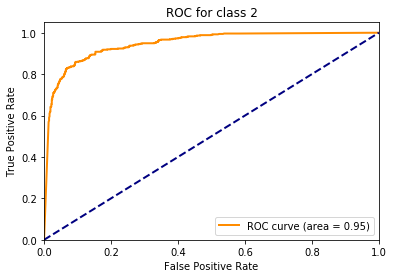

Confusion matric for class {i}
(Actual labels on left)
              0     1 
        0 1142.0  28.0 
        1   4.0  74.0 


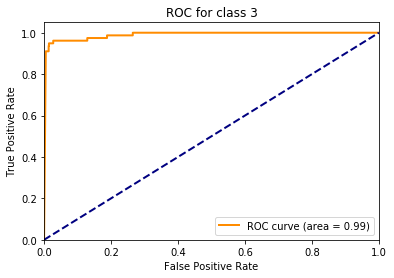

In [26]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
thresholds = [0.5, 0.5, 0.5, 0.5]
for i in range(y_true.shape[-1]):
    y_preds_thresh = (y_preds > thresholds[i]).astype(np.uint8)
    cm = confusion_matrix(y_true[:, i], y_preds_thresh[:, i])
    print('Confusion matric for class {i}\n(Actual labels on left)')
    print_cm(cm, ['0', '1'])
    fpr, tpr, _ = roc_curve(y_true[:, i], y_preds[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for class {i}')
    plt.legend(loc="lower right")
    plt.show()

In [27]:
import cv2

def postprocess(y, y_cls, thresh=None, cls_thresh=None, min_px_area=500):
    if thresh is None:
        thresh = [0.85, 0.85, 0.85, 0.85]
    if cls_thresh is None:
        cls_thresh = [0.5, 0.5, 0.5, 0.5]

    # TODO: handle batches properly
    batches, height, width, classes = y.shape
    assert batches == 1
    
    y_argmax = np.argmax(y, axis=-1) # Only allow one class at each pixel
    y_one_hot = onehottify(y_argmax, y.shape[-1], dtype=int)
    for c in range(classes):
        y_one_hot[:, :, :, c][y[:, :, :, c] < thresh[c]] = 0 # Background
    
    for c in range(classes):
        if y_cls[0, c] < cls_thresh[c]:
            y_one_hot[:, :, :, c] = 0
        else:
            num_component, component = cv2.connectedComponents(y_one_hot[0, :, :, c].astype(np.uint8))
            for comp_idx in range(1, num_component):
                comp_mask = (component == comp_idx)
                if comp_mask.sum() < min_px_area:
                    y_one_hot[0, :, :, c][comp_mask] = 0

    return y_one_hot

def eval(model, dataset, img_list, num_classes=4, thresh=None, cls_thresh=None, verbose=False):
    num_empty_gt = [0] * num_classes
    num_empty_gt_mask_pred = [0] * num_classes
    num_mask_gt_empty_pred = [0] * num_classes
    mask_sizes = [[] for _ in range(num_classes)]

    dice_coeffs = []
    for img_name in img_list:
        img, ann = dataset.get_example_from_img_name(img_name)
        img_batch = np.expand_dims(img, axis=0)
        y, y_cls = model.predict(img_batch)
        y_one_hot = postprocess(y, y_cls, thresh=thresh, cls_thresh=cls_thresh)
        dice_coeffs.append(dice_coeff_kaggle(y_one_hot[0, :, :, :], ann))
        
        for c in range(num_classes):
            gt_mask_size = np.count_nonzero(ann[:, :, c])
            gt_is_empty = gt_mask_size == 0
            pred_is_empty = np.count_nonzero(y_one_hot[0, :, :, c]) == 0
            
            if gt_is_empty:
                num_empty_gt[c] += 1
            else:
                mask_sizes[c].append(gt_mask_size)

            if gt_is_empty and not pred_is_empty:
                num_empty_gt_mask_pred[c] += 1
            
            if not gt_is_empty and pred_is_empty:
                num_mask_gt_empty_pred[c] += 1

    if verbose:
        for c in range(num_classes):
            print(f'**** Class {c} ****')
            print(f'Num empty gt masks: {num_empty_gt[c]}')
            print(f'Num non-empty gt masks: {len(img_list) - num_empty_gt[c]}')
            print(f'Num empty gt mask and non-empty pred: {num_empty_gt_mask_pred[c]} '
                  f'({num_empty_gt_mask_pred[c] / num_empty_gt[c]})')
            print(f'Num non-empty gt mask and empty pred: {num_mask_gt_empty_pred[c]} '
                  f'({num_mask_gt_empty_pred[c] / (len(img_list) - num_empty_gt[c])})')
            print(f'Mean mask size: {np.mean(mask_sizes[c])} (stddev: {np.std(mask_sizes[c])})')
        
    mean_dice_coeff = np.mean(dice_coeffs)
    print(f'Mean dice coeff: {mean_dice_coeff}')
    return mean_dice_coeff, dice_coeffs

In [28]:
mean_dice_coeff, dice_coeffs = eval(cls_model,
                                     dataset,
                                     val_imgs,
                                     thresh=[0.85, 0.85, 0.85, 0.85],
                                     cls_thresh=[0.5, 0.5, 0.5, 0.5])

Mean dice coeff: 0.9325306393964012


In [ ]:
#Mean dice coeff: 0.9327411366608803
#Mean dice coeff: 0.9336561477986604

In [ ]:
indices = np.argsort(dice_coeffs)[:50] # Indices of 10 worst images
for i in indices:
    print(f'{i}: {dice_coeffs[i]}')

In [ ]:
# Visualize Image Prediction
img_id = 936
thresh = 0.85
classification_thresh = [0.5, 0.5, 0.95, 0.5]

img_name = val_imgs[img_id]
img, ann = dataset.get_example_from_img_name(img_name)
img_batch = np.expand_dims(img, axis=0)
y, y_cls = cls_model.predict(img_batch)
plt.figure(figsize=(10, 3))
plt.imshow(visualize_segmentations(np.repeat(img, 3, axis=-1), ann))
plt.show()

for i in range(4):
    plt.figure(figsize=(10, 3))
    plt.imshow(y[0, :, :, i])
    plt.show()
print(f'Mask Classification: {y_cls[0, :]}')
for i in range(y.shape[-1]):
    pred = y[0, :, :, i] > thresh
    if y_cls[0, i] < classification_thresh[i]:
        pred[:, :] = 0
    plt.figure(figsize=(10, 3))
    plt.imshow(pred)
    plt.show()

# Save HDF5 Model

In [ ]:
date_str = datetime.now().strftime("%Y%m%d-%H%M%S")
cls_model.save(f'seg_cls_model_{date_str}.h5')